In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from scipy.stats import norm

# ---------------------------
# 1. Data Pipeline Functions
# ---------------------------

def fetch_historical_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using yfinance.

    Parameters:
    - ticker: Stock ticker symbol.
    - start_date: Start date for historical data.
    - end_date: End date for historical data.

    Returns:
    - Pandas DataFrame with historical data.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Daily Return'] = data['Close'].pct_change()
    return data

def calculate_rsi(prices, window=14):
    """
    Calculate the Relative Strength Index (RSI).

    Parameters:
    - prices: Pandas Series of historical prices.
    - window: Look-back period for RSI calculation.

    Returns:
    - RSI values as a Pandas Series.
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    """
    Calculate MACD and Signal Line.

    Parameters:
    - prices: Pandas Series of historical prices.
    - short_window: Period for the short EMA.
    - long_window: Period for the long EMA.
    - signal_window: Period for the signal line EMA.

    Returns:
    - Tuple of MACD and Signal line as Pandas Series.
    """
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def calculate_volatility(prices):
    """
    Calculate annualized volatility from historical prices.

    Parameters:
    - prices: Pandas Series of historical prices.

    Returns:
    - Annualized volatility as a float or NaN if invalid.
    """
    if prices.isna().any():
        print("Error: Price data contains NaN values.")
        return np.nan

    if len(prices) < 2:
        print("Error: Insufficient price data for volatility calculation.")
        return np.nan

    try:
        log_returns = np.log(prices / prices.shift(1)).dropna()
        return log_returns.std() * np.sqrt(252)  # Annualized volatility
    except Exception as e:
        print(f"Error in volatility calculation: {e}")
        return np.nan

def fetch_strike_prices_with_last_prices(ticker, expiration_date):
    """
    Fetch available strike prices and their corresponding last traded prices for a given ticker and expiration date.

    Parameters:
    - ticker: Stock ticker symbol.
    - expiration_date: Expiration date for the options (YYYY-MM-DD).

    Returns:
    - List of dictionaries with strike prices and last traded prices.
    """
    stock = yf.Ticker(ticker)
    try:
        # Fetch the options chain for the specified expiration date
        options_chain = stock.option_chain(expiration_date)

        # Extract call options
        calls = options_chain.calls

        # Extract strike prices and last prices
        result = [{"strike": row["strike"], "lastPrice": row["lastPrice"]}
                  for _, row in calls.iterrows()]
        return result
    except Exception as e:
        print(f"Error fetching strike prices and last prices for {ticker} on {expiration_date}: {e}")
        return []  # Return an empty list on error


def calculate_time_to_expiration(expiration_date):
    """
    Calculate time to expiration in years.

    Parameters:
    - expiration_date: Expiration date (YYYY-MM-DD).

    Returns:
    - Time to expiration as a float in years.
    """
    today = datetime.now()
    expiration = datetime.strptime(expiration_date, '%Y-%m-%d')
    days_to_expiration = (expiration - today).days
    if days_to_expiration <= 0:
        print(f"The expiration date {expiration_date} has already passed or is invalid.")
        return np.nan
    return days_to_expiration / 365  # Convert days to years

# ---------------------------
# 2. Black-Scholes Pricing Model
# ---------------------------

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Calculate the price of an option using the Black-Scholes model.

    Returns:
    - Option price as a float.
    """
    try:
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == "call":
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == "put":
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    except Exception as e:
        print(f"Error in Black-Scholes calculation: {e}")
        return np.nan

def calculate_greeks(S, K, T, r, sigma, option_type="call"):
    """
    Calculate option Greeks using the Black-Scholes model.

    Returns:
    - Dictionary containing Delta, Gamma, Vega, Theta, and Rho as floats.
    """
    try:
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T) / 100

        if option_type == "call":
            delta = norm.cdf(d1)
            theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) -
                     r * K * np.exp(-r * T) * norm.cdf(d2)) / 365
            rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100
        elif option_type == "put":
            delta = -norm.cdf(-d1)
            theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) +
                     r * K * np.exp(-r * T) * norm.cdf(-d2)) / 365
            rho = -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100

        return {"Delta": delta, "Gamma": gamma, "Vega": vega, "Theta": theta, "Rho": rho}
    except Exception as e:
        print(f"Error in Greeks calculation: {e}")
        return {"Delta": np.nan, "Gamma": np.nan, "Vega": np.nan, "Theta": np.nan, "Rho": np.nan}

In [2]:
# List of stocks and expiration date
tickers = ["ACN","SAP","ASML","NXPI","SPOT","VOD","ERIC","LOGI","NVO","TEAM","ARM","UBS", "DB","HSBC"]
expiration_date = "2024-12-20"
r = 0.05  # Risk-free interest rate

# Initialize results list
predicted_prices = []

# Loop through each stock
for ticker in tickers:
    print(f"Processing {ticker}...")
    try:
        # Fetch historical data for the ticker
        historical_data = fetch_historical_data(ticker, start_date="2020-01-01", end_date="2025-01-01")
        if historical_data.empty:
            print(f"No data found for {ticker}. Skipping...")
            continue

        # Calculate volatility
        sigma = calculate_volatility(historical_data['Close'].squeeze())
        if np.isnan(sigma):
            print(f"Unable to calculate volatility for {ticker}. Skipping...")
            continue

        # Spot price (last close price)
        S = historical_data['Close'].iloc[-1]

        # Calculate MACD and RSI (optional, for analysis)
        historical_data['MACD'], historical_data['Signal'] = calculate_macd(historical_data['Close'])
        historical_data['RSI'] = calculate_rsi(historical_data['Close'])

        # Calculate time to expiration
        T = calculate_time_to_expiration(expiration_date)
        if np.isnan(T):
            print(f"Invalid expiration date for {ticker}. Skipping...")
            continue

        # Fetch strike prices
        strike_prices_with_last_prices = fetch_strike_prices_with_last_prices(ticker, expiration_date)
        if not strike_prices_with_last_prices:
            print(f"No strike prices available for {ticker}. Skipping...")
            continue
        # Extract only strike prices
        strike_prices = [option["strike"] for option in strike_prices_with_last_prices]

        # Extract only last prices
        last_prices = [option["lastPrice"] for option in strike_prices_with_last_prices]

        # Calculate option prices and Greeks for each strike price
        for option in strike_prices_with_last_prices:
            K = option["strike"]
            real_price = option["lastPrice"]
            price = black_scholes(S, K, T, r, sigma, option_type="call")
            greeks = calculate_greeks(S, K, T, r, sigma, option_type="call")
            predicted_prices.append({
                "Ticker": ticker,
                "Strike Price": K,
                "Price": price,
                "Spot Price": S,
                "Real Price": real_price,
                **greeks
            })
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Convert results to a DataFrame
predicted_prices_df = pd.DataFrame(predicted_prices)

# Display the results
predicted_prices_df

Processing ACN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing SAP...



[*********************100%***********************]  1 of 1 completed

Processing ASML...



[*********************100%***********************]  1 of 1 completed

Processing NXPI...


Processing SPOT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing VOD...


Processing ERIC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing LOGI...


Processing NVO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing TEAM...



[*********************100%***********************]  1 of 1 completed

Processing ARM...



[*********************100%***********************]  1 of 1 completed

Processing UBS...


Processing DB...


[*********************100%***********************]  1 of 1 completed


Processing HSBC...


[*********************100%***********************]  1 of 1 completed


,Ticker,Strike Price,Price,Spot Price,Real Price,Delta,Gamma,Vega,Theta,Rho
0,ACN,300.0,Ticker ACN 58.666768 Name: 2024-12-05 00:00...,Ticker ACN 358.130005 Name: 2024-12-05 00:0...,57.86,[0.9994403428211864],Ticker ACN 0.000099 Name: 2024-12-05 00:00:...,Ticker ACN 0.001333 Name: 2024-12-05 00:00:...,Ticker ACN -0.042499 Name: 2024-12-05 00:00:...,[0.10658675316588478]
1,ACN,305.0,Ticker ACN 53.681521 Name: 2024-12-05 00:00...,Ticker ACN 358.130005 Name: 2024-12-05 00:0...,46.56,[0.9984625370773794],Ticker ACN 0.000252 Name: 2024-12-05 00:00:...,Ticker ACN 0.003373 Name: 2024-12-05 00:00:...,Ticker ACN -0.045436 Name: 2024-12-05 00:00:...,[0.10823759839989852]
2,ACN,310.0,Ticker ACN 48.705393 Name: 2024-12-05 00:00...,Ticker ACN 358.130005 Name: 2024-12-05 00:0...,53.72,[0.9961673410673461],Ticker ACN 0.000575 Name: 2024-12-05 00:00:...,Ticker ACN 0.007706 Name: 2024-12-05 00:00:...,Ticker ACN -0.050895 Name: 2024-12-05 00:00:...,[0.10971715836358321]
3,ACN,315.0,Ticker ACN 43.749184 Name: 2024-12-05 00:00...,Ticker ACN 358.130005 Name: 2024-12-05 00:0...,47.77,[0.9912844469276726],Ticker ACN 0.001192 Name: 2024-12-05 00:00:...,Ticker ACN 0.015972 Name: 2024-12-05 00:00:...,Ticker ACN -0.060661 Name: 2024-12-05 00:00:...,[0.11085955501058567]
4,ACN,320.0,Ticker ACN 38.832543 Name: 2024-12-05 00:00...,Ticker ACN 358.130005 Name: 2024-12-05 00:0...,40.10,[0.9818279315730729],Ticker ACN 0.002251 Name: 2024-12-05 00:00:...,Ticker ACN 0.030163 Name: 2024-12-05 00:00:...,Ticker ACN -0.076884 Name: 2024-12-05 00:00:...,[0.11140447899139534]
...,...,...,...,...,...,...,...,...,...,...
524,HSBC,49.0,Ticker HSBC 0.720626 Name: 2024-12-05 00:00...,Ticker HSBC 48.060001 Name: 2024-12-05 00:0...,0.35,[0.3887851442251505],Ticker HSBC 0.140933 Name: 2024-12-05 00:00...,Ticker HSBC 0.034769 Name: 2024-12-05 00:00...,Ticker HSBC -0.042564 Name: 2024-12-05 00:00...,[0.006398275371598473]
525,HSBC,50.0,Ticker HSBC 0.418039 Name: 2024-12-05 00:00...,Ticker HSBC 48.060001 Name: 2024-12-05 00:0...,0.09,[0.26126527723259985],Ticker HSBC 0.11955 Name: 2024-12-05 00:00:...,Ticker HSBC 0.029494 Name: 2024-12-05 00:00...,Ticker HSBC -0.035681 Name: 2024-12-05 00:00...,[0.004323255375716192]
526,HSBC,51.0,Ticker HSBC 0.225452 Name: 2024-12-05 00:00...,Ticker HSBC 48.060001 Name: 2024-12-05 00:0...,0.06,[0.16124762790402153],Ticker HSBC 0.089907 Name: 2024-12-05 00:00...,Ticker HSBC 0.022181 Name: 2024-12-05 00:00...,Ticker HSBC -0.026614 Name: 2024-12-05 00:00...,[0.0026798198871295625]
527,HSBC,52.0,Ticker HSBC 0.112916 Name: 2024-12-05 00:00...,Ticker HSBC 48.060001 Name: 2024-12-05 00:0...,0.06,[0.09135742708928696],Ticker HSBC 0.060369 Name: 2024-12-05 00:00...,Ticker HSBC 0.014893 Name: 2024-12-05 00:00...,Ticker HSBC -0.017764 Name: 2024-12-05 00:00...,[0.0015235722918653216]


In [3]:
def clean_column_values(df, columns):
    """
    Clean columns by extracting scalar values from arrays, lists, or pandas Series.

    Parameters:
    - df: DataFrame containing the data to clean.
    - columns: List of column names to clean.

    Returns:
    - Cleaned DataFrame with scalar values in the specified columns.
    """
    for column in columns:
        df[column] = df[column].apply(
            lambda x: x[0] if isinstance(x, (np.ndarray, list)) else float(x)
            if isinstance(x, (pd.Series, float, int)) else np.nan
        )
    return df


# List of columns to clean
columns_to_clean = ['Price', 'Delta', 'Spot Price', 'Real Price', 'Gamma', 'Vega', 'Theta', 'Rho']

# Clean the DataFrame
cleaned_predicted_prices_df = clean_column_values(predicted_prices_df, columns_to_clean)
cleaned_predicted_prices_df

<ipython-input-3-e2c2b0b6ef3b>:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lambda x: x[0] if isinstance(x, (np.ndarray, list)) else float(x)


,Ticker,Strike Price,Price,Spot Price,Real Price,Delta,Gamma,Vega,Theta,Rho
0,ACN,300.0,58.666768,358.130005,57.86,0.999440,0.000099,0.001333,-0.042499,0.106587
1,ACN,305.0,53.681521,358.130005,46.56,0.998463,0.000252,0.003373,-0.045436,0.108238
2,ACN,310.0,48.705393,358.130005,53.72,0.996167,0.000575,0.007706,-0.050895,0.109717
3,ACN,315.0,43.749184,358.130005,47.77,0.991284,0.001192,0.015972,-0.060661,0.110860
4,ACN,320.0,38.832543,358.130005,40.10,0.981828,0.002251,0.030163,-0.076884,0.111404
...,...,...,...,...,...,...,...,...,...,...
524,HSBC,49.0,0.720626,48.060001,0.35,0.388785,0.140933,0.034769,-0.042564,0.006398
525,HSBC,50.0,0.418039,48.060001,0.09,0.261265,0.119550,0.029494,-0.035681,0.004323
526,HSBC,51.0,0.225452,48.060001,0.06,0.161248,0.089907,0.022181,-0.026614,0.002680
527,HSBC,52.0,0.112916,48.060001,0.06,0.091357,0.060369,0.014893,-0.017764,0.001524


In [4]:
def validate_greeks(predicted_df):
    """
    Validate Greeks for consistency and theoretical expectations.

    Parameters:
    - predicted_df: DataFrame containing option prices and Greeks.

    Returns:
    - DataFrame highlighting any inconsistencies.
    """
    inconsistencies = []
    for _, row in predicted_df.iterrows():
        ticker = row["Ticker"]
        delta, gamma, vega, theta, rho = row["Delta"], row["Gamma"], row["Vega"], row["Theta"], row["Rho"]

        if not (0 <= delta <= 1):  # Delta for call options
            inconsistencies.append({"Ticker": ticker, "Issue": "Delta out of range", "Value": delta})
        if gamma < 0:
            inconsistencies.append({"Ticker": ticker, "Issue": "Gamma is negative", "Value": gamma})
        if vega < 0:
            inconsistencies.append({"Ticker": ticker, "Issue": "Vega is negative", "Value": vega})
        if theta > 0:
            inconsistencies.append({"Ticker": ticker, "Issue": "Theta is positive", "Value": theta})

    return pd.DataFrame(inconsistencies)

# Example Usage
greeks_issues_df = validate_greeks(cleaned_predicted_prices_df)
print(greeks_issues_df)

Empty DataFrame
Columns: []
Index: []


In [5]:
def validate_boundary_conditions(predicted_df, tolerance=1):
    """
    Validate model output for boundary conditions.

    Parameters:
    - predicted_df: DataFrame containing option prices.
    - tolerance: Tolerance for validation checks.

    Returns:
    - DataFrame highlighting any boundary condition failures.
    """
    issues = []
    for _, row in predicted_df.iterrows():
        ticker = row["Ticker"]
        spot_price = row["Spot Price"]
        strike_price = row["Strike Price"]
        price = row["Price"]
        delta = row.get("Delta", None)  # Optional

        # Calculate intrinsic value
        intrinsic_value = max(spot_price - strike_price, 0)

        # Deep in-the-money call
        if strike_price < spot_price:
            if abs(price - intrinsic_value) > tolerance:
                issues.append({
                    "Ticker": ticker,
                    "Spot Price": spot_price,
                    "Strike Price": strike_price,
                    "Intrinsic Value": intrinsic_value,
                    "Predicted Price": price,
                    "Delta": delta,
                    "Issue": "Deep in-the-money mismatch"
                })

        # Deep out-of-the-money call
        if strike_price > spot_price:
            if price > (0.02 * spot_price):  # Allow small value based on volatility/time
                issues.append({
                    "Ticker": ticker,
                    "Spot Price": spot_price,
                    "Strike Price": strike_price,
                    "Intrinsic Value": intrinsic_value,
                    "Predicted Price": price,
                    "Delta": delta,
                    "Issue": "Deep out-of-the-money mismatch"
                })

    return pd.DataFrame(issues)

boundary_issues_df = validate_boundary_conditions(cleaned_predicted_prices_df)
boundary_issues_df

,Ticker,Spot Price,Strike Price,Intrinsic Value,Predicted Price,Delta,Issue
0,ACN,358.130005,330.0,28.130005,29.262247,0.937889,Deep in-the-money mismatch
1,ACN,358.130005,335.0,23.130005,24.719606,0.897189,Deep in-the-money mismatch
2,ACN,358.130005,337.5,20.630005,22.540182,0.871059,Deep in-the-money mismatch
3,ACN,358.130005,340.0,18.130005,20.435410,0.840889,Deep in-the-money mismatch
4,ACN,358.130005,345.0,13.130005,16.489801,0.768663,Deep in-the-money mismatch
...,...,...,...,...,...,...,...
143,ARM,137.949997,152.5,0.000000,3.315177,0.279702,Deep out-of-the-money mismatch
144,ARM,137.949997,155.0,0.000000,2.777334,0.244330,Deep out-of-the-money mismatch
145,UBS,32.740002,33.0,0.000000,0.762014,0.475803,Deep out-of-the-money mismatch
146,DB,17.930000,18.0,0.000000,0.558324,0.505611,Deep out-of-the-money mismatch


In [6]:
boundary_issues_df.groupby(['Ticker', 'Issue']).size().reset_index(name='Count')

,Ticker,Issue,Count
0,ACN,Deep in-the-money mismatch,9
1,ACN,Deep out-of-the-money mismatch,1
2,ARM,Deep in-the-money mismatch,22
3,ARM,Deep out-of-the-money mismatch,8
4,ASML,Deep in-the-money mismatch,34
5,ASML,Deep out-of-the-money mismatch,5
6,DB,Deep out-of-the-money mismatch,1
7,HSBC,Deep in-the-money mismatch,1
8,LOGI,Deep in-the-money mismatch,1
9,LOGI,Deep out-of-the-money mismatch,1


In [7]:
def compare_with_real_world(predicted_df):
    """
    Compare predicted option prices with real-world prices from a DataFrame column.

    Parameters:
    - predicted_df: DataFrame containing predicted option prices and real-world prices.
    - real_price_column: Column name in the DataFrame containing real-world prices.

    Returns:
    - DataFrame with real-world prices and percentage errors.
    """

    results = []
    for _, row in predicted_df.iterrows():
        ticker = row["Ticker"]
        strike = row["Strike Price"]
        predicted_price = row["Price"]
        real_price = row["Real Price"]

        if not pd.isna(real_price) and real_price > 0:
            percentage_error = abs((predicted_price - real_price) / real_price) * 100
            results.append({
                "Ticker": ticker,
                "Strike Price": strike,
                "Predicted Price": predicted_price,
                "Real Price": real_price,
                "Percentage Error": percentage_error
            })

    return pd.DataFrame(results)

comparison_with_real_prices = compare_with_real_world(cleaned_predicted_prices_df)
comparison_with_real_prices

,Ticker,Strike Price,Predicted Price,Real Price,Percentage Error
0,ACN,300.0,58.666768,57.86,1.394345
1,ACN,305.0,53.681521,46.56,15.295363
2,ACN,310.0,48.705393,53.72,9.334711
3,ACN,315.0,43.749184,47.77,8.417032
4,ACN,320.0,38.832543,40.10,3.160740
...,...,...,...,...,...
524,HSBC,49.0,0.720626,0.35,105.893149
525,HSBC,50.0,0.418039,0.09,364.487467
526,HSBC,51.0,0.225452,0.06,275.752559
527,HSBC,52.0,0.112916,0.06,88.193112


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_mae(predicted_df, real_price_column="Real Price"):
    """
    Calculate MAE for each ticker and overall MAE.

    Parameters:
    - predicted_df: DataFrame containing predicted and real prices.
    - real_price_column: Column name for real prices in the DataFrame.

    Returns:
    - DataFrame with MAE for each ticker.
    """
    if real_price_column not in predicted_df.columns:
        raise ValueError(f"Column '{real_price_column}' not found in DataFrame.")

    mae_results = []
    for ticker, group in predicted_df.groupby("Ticker"):
        y_pred = group["Price"]
        y_true = group[real_price_column]
        mae = mean_absolute_error(y_true, y_pred)
        mae_results.append({"Ticker": ticker, "MAE": mae})

    overall_mae = mean_absolute_error(predicted_df[real_price_column], predicted_df["Price"])
    mae_results.append({"Ticker": "Overall", "MAE": overall_mae})

    return pd.DataFrame(mae_results)


def calculate_rmse(predicted_df, real_price_column="Real Price"):
    """
    Calculate RMSE for each ticker and overall RMSE.

    Parameters:
    - predicted_df: DataFrame containing predicted and real prices.
    - real_price_column: Column name for real prices in the DataFrame.

    Returns:
    - DataFrame with RMSE for each ticker.
    """
    if real_price_column not in predicted_df.columns:
        raise ValueError(f"Column '{real_price_column}' not found in DataFrame.")

    rmse_results = []
    for ticker, group in predicted_df.groupby("Ticker"):
        y_pred = group["Price"]
        y_true = group[real_price_column]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_results.append({"Ticker": ticker, "RMSE": rmse})

    overall_rmse = np.sqrt(mean_squared_error(predicted_df[real_price_column], predicted_df["Price"]))
    rmse_results.append({"Ticker": "Overall", "RMSE": overall_rmse})

    return pd.DataFrame(rmse_results)


def calculate_r2(predicted_df, real_price_column="Real Price"):
    """
    Calculate R² score for each ticker and overall R² score.

    Parameters:
    - predicted_df: DataFrame containing predicted and real prices.
    - real_price_column: Column name for real prices in the DataFrame.

    Returns:
    - DataFrame with R² score for each ticker.
    """
    if real_price_column not in predicted_df.columns:
        raise ValueError(f"Column '{real_price_column}' not found in DataFrame.")

    r2_results = []
    for ticker, group in predicted_df.groupby("Ticker"):
        y_pred = group["Price"]
        y_true = group[real_price_column]
        r2 = r2_score(y_true, y_pred)
        r2_results.append({"Ticker": ticker, "R²": r2})

    overall_r2 = r2_score(predicted_df[real_price_column], predicted_df["Price"])
    r2_results.append({"Ticker": "Overall", "R²": overall_r2})

    return pd.DataFrame(r2_results)

mae = calculate_mae(cleaned_predicted_prices_df)

# Calculate RMSE
rmse = calculate_rmse(cleaned_predicted_prices_df)

# Calculate R²
r2 = calculate_r2(cleaned_predicted_prices_df)


In [9]:
mae

,Ticker,MAE
0,ACN,2.090713
1,ARM,2.518575
2,ASML,5.247713
3,DB,0.443871
4,ERIC,0.278344
5,HSBC,1.298812
6,LOGI,2.410995
7,NVO,1.789402
8,NXPI,3.332107
9,SAP,17.339499


In [10]:
rmse

,Ticker,RMSE
0,ACN,2.816552
1,ARM,4.114339
2,ASML,11.390893
3,DB,0.651973
4,ERIC,0.486508
5,HSBC,2.151680
6,LOGI,5.245156
7,NVO,2.385364
8,NXPI,7.696686
9,SAP,27.252864


In [11]:
r2

,Ticker,R²
0,ACN,0.972088
1,ARM,0.968940
2,ASML,0.965215
3,DB,0.931233
4,ERIC,0.944600
5,HSBC,0.316723
6,LOGI,0.897761
7,NVO,0.946654
8,NXPI,0.925431
9,SAP,-0.238999


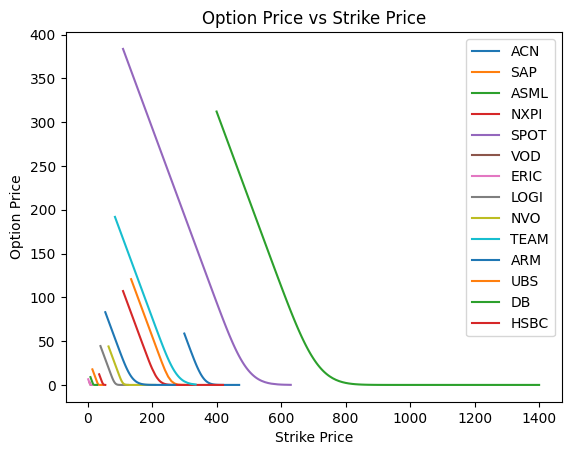

In [12]:
import matplotlib.pyplot as plt

def plot_option_price_vs_strike(df):
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        plt.plot(subset["Strike Price"], subset["Price"], label=ticker)
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.title("Option Price vs Strike Price")
    plt.legend()
    plt.show()

plot_option_price_vs_strike(cleaned_predicted_prices_df)

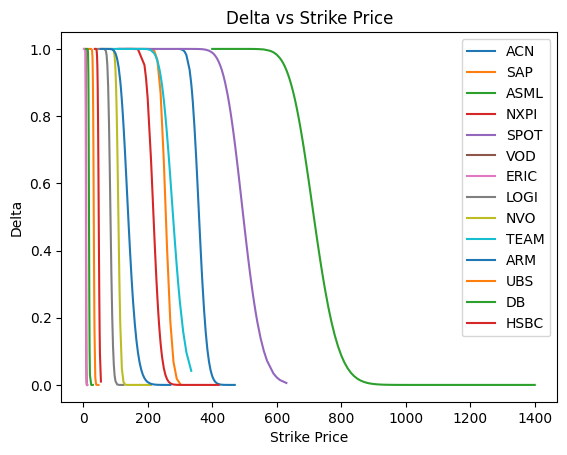

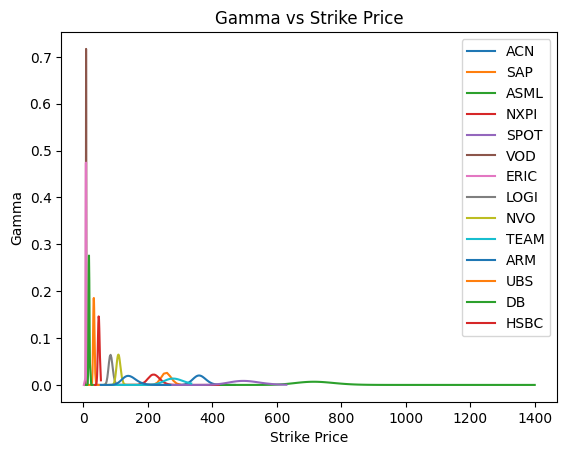

In [13]:
def plot_greeks_vs_strike(df, greek):
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        plt.plot(subset["Strike Price"], subset[greek], label=ticker)
    plt.xlabel("Strike Price")
    plt.ylabel(greek)
    plt.title(f"{greek} vs Strike Price")
    plt.legend()
    plt.show()

plot_greeks_vs_strike(cleaned_predicted_prices_df, "Delta")
plot_greeks_vs_strike(cleaned_predicted_prices_df, "Gamma")


In [14]:
from datetime import datetime

# Function to calculate annualized volatility from historical prices
def calculate_volatility(prices):
    log_returns = np.log(prices / prices.shift(1)).dropna()
    return log_returns.std() * np.sqrt(252)  # Annualized volatility

# Function to calculate time to expiration
def calculate_time_to_expiration(expiration_date):
    today = datetime.now()
    expiration = datetime.strptime(expiration_date, '%Y-%m-%d')
    days_to_expiration = (expiration - today).days
    if days_to_expiration <= 0:
        return np.nan
    return days_to_expiration / 365  # Convert days to years

# Example: Setting expiration date
expiration_date = "2024-12-20"

# Calculate `T` (time to expiration)
cleaned_predicted_prices_df['Time to Expiration'] = cleaned_predicted_prices_df.apply(
    lambda row: calculate_time_to_expiration(expiration_date), axis=1
)

# Calculate `sigma` (volatility)
# Merge historical prices to `cleaned_predicted_prices_df` to get the volatility
cleaned_predicted_prices_df['Volatility'] = cleaned_predicted_prices_df.apply(
    lambda row: calculate_volatility(historical_data['Close']), axis=1
)

# Calculate Residual Error
cleaned_predicted_prices_df['Residual Error'] = cleaned_predicted_prices_df['Real Price'] - cleaned_predicted_prices_df['Price']

In [15]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features for the ML model
features = ['Spot Price', 'Strike Price', 'Time to Expiration', 'Volatility',
            'Delta', 'Gamma', 'Vega', 'Theta', 'Rho', 'Price']

# Define X (features) and y (target variable)
X = cleaned_predicted_prices_df[features]
y = cleaned_predicted_prices_df['Residual Error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train the XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict residual errors on the test set
rf_predicted_residuals = rf_model.predict(X_test)
xgb_predicted_residuals = xgb_model.predict(X_test)

# Calculate the corrected prices
X_test['RF Corrected Price'] = X_test['Price'] + rf_predicted_residuals
X_test['XGB Corrected Price'] = X_test['Price'] + xgb_predicted_residuals

# Create a DataFrame to compare the predictions
comparison_df = X_test.copy()
comparison_df['Real Price'] = y_test + X_test['Price']
comparison_df['Black-Scholes Price'] = X_test['Price']
comparison_df['RF Predicted Residuals'] = rf_predicted_residuals
comparison_df['RF Corrected Price'] = X_test['RF Corrected Price']
comparison_df['XGB Predicted Residuals'] = xgb_predicted_residuals
comparison_df['XGB Corrected Price'] = X_test['XGB Corrected Price']

# Calculate evaluation metrics
mae_bs = mean_absolute_error(comparison_df['Real Price'], comparison_df['Black-Scholes Price'])
mae_rf_corrected = mean_absolute_error(comparison_df['Real Price'], comparison_df['RF Corrected Price'])
mae_xgb_corrected = mean_absolute_error(comparison_df['Real Price'], comparison_df['XGB Corrected Price'])

rmse_bs = np.sqrt(mean_squared_error(comparison_df['Real Price'], comparison_df['Black-Scholes Price']))
rmse_rf_corrected = np.sqrt(mean_squared_error(comparison_df['Real Price'], comparison_df['RF Corrected Price']))
rmse_xgb_corrected = np.sqrt(mean_squared_error(comparison_df['Real Price'], comparison_df['XGB Corrected Price']))

r2_bs = r2_score(comparison_df['Real Price'], comparison_df['Black-Scholes Price'])
r2_rf_corrected = r2_score(comparison_df['Real Price'], comparison_df['RF Corrected Price'])
r2_xgb_corrected = r2_score(comparison_df['Real Price'], comparison_df['XGB Corrected Price'])

# Print evaluation results
metrics = {
    'Model': ['Black-Scholes', 'RandomForest Corrected', 'XGBoost Corrected'],
    'MAE': [mae_bs, mae_rf_corrected, mae_xgb_corrected],
    'RMSE': [rmse_bs, rmse_rf_corrected, rmse_xgb_corrected],
    'R²': [r2_bs, r2_rf_corrected, r2_xgb_corrected]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


                    Model       MAE       RMSE        R²
0           Black-Scholes  8.649295  26.459961  0.676992
1  RandomForest Corrected  5.772457  12.946055  0.922677
2       XGBoost Corrected  6.919661  16.735964  0.870778


In [16]:
# Display the comparison DataFrame
pd.options.display.float_format = '{:.6f}'.format
comparison_df_to_display = comparison_df[['Real Price', 'Black-Scholes Price', 'RF Corrected Price', 'XGB Corrected Price']]
print(comparison_df_to_display.head(10))  # Display the first 10 rows for brevity

     Real Price  Black-Scholes Price  RF Corrected Price  XGB Corrected Price
140    0.050000             0.000001            0.184200             0.128249
397   37.450000            33.826799           18.851603            12.707397
6     25.150000            24.719606           24.784812            29.249934
334   11.480000             9.161710           11.049781            10.720814
322   33.920000            33.953442           33.449570            33.476077
82    50.370000            54.086943           60.071628            60.821071
225  187.600000           204.025989          187.986195           188.500353
495    0.230000             0.000000            0.297044             0.396597
522    1.450000             1.739480            1.257897             1.212988
101   11.600000            16.176835           11.630988            11.489948


In [17]:
pip install dash plotly pandas


In [18]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import pandas as pd

# Initialize Dash app
app = dash.Dash(__name__)

# Load your DataFrame (assuming it's already cleaned)
df = cleaned_predicted_prices_df  # Replace with your actual cleaned DataFrame

# Create a plot for Predicted vs Real Option Prices
def create_scatter_plot(ticker):
    filtered_df = df[df['Ticker'] == ticker]
    fig = px.scatter(filtered_df, x='Price', y='Real Price', color='Ticker',
                     title=f"Predicted vs Real Option Prices for {ticker}",
                     labels={"Price": "Predicted Price", "Real Price": "Real Price"})
    fig.add_shape(type='line', x0=0, y0=0, x1=filtered_df['Real Price'].max(), y1=filtered_df['Real Price'].max(),
                  line=dict(color="gray", dash="dash"), name="y=x (Ideal)")
    return fig

# Create a bar chart for MAE, RMSE, and R² metrics
def create_metrics_bar_plot():
    metrics_df = pd.DataFrame({
        'Metric': ['MAE', 'RMSE', 'R²'],
        'Value': [mae['MAE'].mean(), rmse['RMSE'].mean(), r2['R²'].mean()]
    })
    fig = px.bar(metrics_df, x='Metric', y='Value', color='Metric',
                 title="Overall Model Performance Metrics",
                 labels={"Metric": "Metric", "Value": "Value"})
    return fig

# Define layout for the dashboard
app.layout = html.Div([
    html.H1("Option Pricing Model Dashboard"),

    # Dropdown for ticker selection
    html.Div([
        dcc.Dropdown(
            id='ticker-dropdown',
            options=[{'label': ticker, 'value': ticker} for ticker in df['Ticker'].unique()],
            value=df['Ticker'].unique()[0],  # Default value
            style={'width': '50%'}
        )
    ]),

    # Graphs for Predicted vs Real Option Prices
    html.Div([
        dcc.Graph(id='predicted-vs-real-price')
    ], style={'margin-top': '20px'}),

    # Graphs for Model Performance Metrics
    html.Div([
        dcc.Graph(id='model-performance-metrics')
    ], style={'margin-top': '20px'}),
])

# Define callbacks to update graphs dynamically
@app.callback(
    [Output('predicted-vs-real-price', 'figure'),
     Output('model-performance-metrics', 'figure')],
    [Input('ticker-dropdown', 'value')]
)
def update_graphs(ticker):
    scatter_fig = create_scatter_plot(ticker)
    bar_fig = create_metrics_bar_plot()
    return scatter_fig, bar_fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<ipython-input-18-045abd0b313d>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-18-045abd0b313d>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


<IPython.core.display.Javascript object>

Aastha: ML


In [19]:
from datetime import datetime

# Function to calculate annualized volatility from historical prices
def calculate_volatility(prices):
    log_returns = np.log(prices / prices.shift(1)).dropna()
    return log_returns.std() * np.sqrt(252)  # Annualized volatility

# Function to calculate time to expiration
def calculate_time_to_expiration(expiration_date):
    today = datetime.now()
    expiration = datetime.strptime(expiration_date, '%Y-%m-%d')
    days_to_expiration = (expiration - today).days
    if days_to_expiration <= 0:
        return np.nan
    return days_to_expiration / 365  # Convert days to years

# Example: Setting expiration date
expiration_date = "2024-12-20"

# Calculate `T` (time to expiration)
cleaned_predicted_prices_df['Time to Expiration'] = cleaned_predicted_prices_df.apply(
    lambda row: calculate_time_to_expiration(expiration_date), axis=1
)

# Calculate `sigma` (volatility)
# Merge historical prices to `cleaned_predicted_prices_df` to get the volatility
cleaned_predicted_prices_df['Volatility'] = cleaned_predicted_prices_df.apply(
    lambda row: calculate_volatility(historical_data['Close']), axis=1
)

# Calculate Residual Error
cleaned_predicted_prices_df['Residual Error'] = cleaned_predicted_prices_df['Real Price'] - cleaned_predicted_prices_df['Price']

In [20]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features for the ML model
features = ['Spot Price', 'Strike Price', 'Time to Expiration', 'Volatility',
            'Delta', 'Gamma', 'Vega', 'Theta', 'Rho', 'Price']

# Define X (features) and y (target variable)
X = cleaned_predicted_prices_df[features]
y = cleaned_predicted_prices_df['Residual Error']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train the XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict residual errors on the test set
rf_predicted_residuals = rf_model.predict(X_test)
xgb_predicted_residuals = xgb_model.predict(X_test)

# Calculate the corrected prices
X_test['RF Corrected Price'] = X_test['Price'] + rf_predicted_residuals
X_test['XGB Corrected Price'] = X_test['Price'] + xgb_predicted_residuals

# Create a DataFrame to compare the predictions
comparison_df = X_test.copy()
comparison_df['Real Price'] = y_test + X_test['Price']
comparison_df['Black-Scholes Price'] = X_test['Price']
comparison_df['RF Predicted Residuals'] = rf_predicted_residuals
comparison_df['RF Corrected Price'] = X_test['RF Corrected Price']
comparison_df['XGB Predicted Residuals'] = xgb_predicted_residuals
comparison_df['XGB Corrected Price'] = X_test['XGB Corrected Price']

# Calculate evaluation metrics
mae_bs = mean_absolute_error(comparison_df['Real Price'], comparison_df['Black-Scholes Price'])
mae_rf_corrected = mean_absolute_error(comparison_df['Real Price'], comparison_df['RF Corrected Price'])
mae_xgb_corrected = mean_absolute_error(comparison_df['Real Price'], comparison_df['XGB Corrected Price'])

rmse_bs = np.sqrt(mean_squared_error(comparison_df['Real Price'], comparison_df['Black-Scholes Price']))
rmse_rf_corrected = np.sqrt(mean_squared_error(comparison_df['Real Price'], comparison_df['RF Corrected Price']))
rmse_xgb_corrected = np.sqrt(mean_squared_error(comparison_df['Real Price'], comparison_df['XGB Corrected Price']))

r2_bs = r2_score(comparison_df['Real Price'], comparison_df['Black-Scholes Price'])
r2_rf_corrected = r2_score(comparison_df['Real Price'], comparison_df['RF Corrected Price'])
r2_xgb_corrected = r2_score(comparison_df['Real Price'], comparison_df['XGB Corrected Price'])

# Print evaluation results
metrics = {
    'Model': ['Black-Scholes', 'RandomForest Corrected', 'XGBoost Corrected'],
    'MAE': [mae_bs, mae_rf_corrected, mae_xgb_corrected],
    'RMSE': [rmse_bs, rmse_rf_corrected, rmse_xgb_corrected],
    'R²': [r2_bs, r2_rf_corrected, r2_xgb_corrected]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

                    Model      MAE      RMSE       R²
0           Black-Scholes 8.649295 26.459961 0.676992
1  RandomForest Corrected 5.772457 12.946055 0.922677
2       XGBoost Corrected 6.919661 16.735964 0.870778


In [21]:
# Reset the index to remove the additional row numbers
comparison_df_cleaned = comparison_df[['Real Price', 'Black-Scholes Price', 'RF Corrected Price', 'XGB Corrected Price']].reset_index(drop=True)

# Convert scientific notation to standard floating point for better readability
pd.options.display.float_format = '{:.6f}'.format

# Display the cleaned DataFrame
print(comparison_df_cleaned.head(10))  # Display the first 10 rows

   Real Price  Black-Scholes Price  RF Corrected Price  XGB Corrected Price
0    0.050000             0.000001            0.184200             0.128249
1   37.450000            33.826799           18.851603            12.707397
2   25.150000            24.719606           24.784812            29.249934
3   11.480000             9.161710           11.049781            10.720814
4   33.920000            33.953442           33.449570            33.476077
5   50.370000            54.086943           60.071628            60.821071
6  187.600000           204.025989          187.986195           188.500353
7    0.230000             0.000000            0.297044             0.396597
8    1.450000             1.739480            1.257897             1.212988
9   11.600000            16.176835           11.630988            11.489948


**Visualizations**

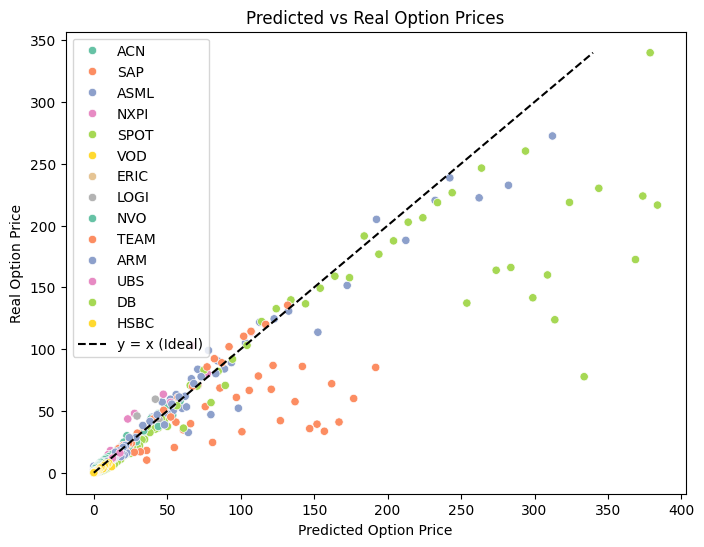

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of predicted vs real prices
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Price', y='Real Price', data=cleaned_predicted_prices_df, hue='Ticker', palette='Set2')
plt.plot([0, cleaned_predicted_prices_df['Real Price'].max()],
         [0, cleaned_predicted_prices_df['Real Price'].max()], 'k--', label="y = x (Ideal)")
plt.title('Predicted vs Real Option Prices')
plt.xlabel('Predicted Option Price')
plt.ylabel('Real Option Price')
plt.legend()
plt.show()
#It helps assess how well your model is performing by showing the correlation between actual and predicted prices.

In [23]:
import plotly.express as px

def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    fig = px.bar(feature_importance_df, x='Feature', y='Importance', title="Feature Importance")
    fig.show()


In [24]:
import plotly.express as px

def plot_residuals(predicted_df):
    residuals = predicted_df['Price'] - predicted_df['Real Price']
    fig = px.scatter(predicted_df, x='Price', y=residuals, color='Ticker',
                     title="Residuals: Predicted vs Actual Prices",
                     labels={"Price": "Predicted Price", "y": "Residuals"})
    fig.show()

# Example usage
plot_residuals(cleaned_predicted_prices_df)

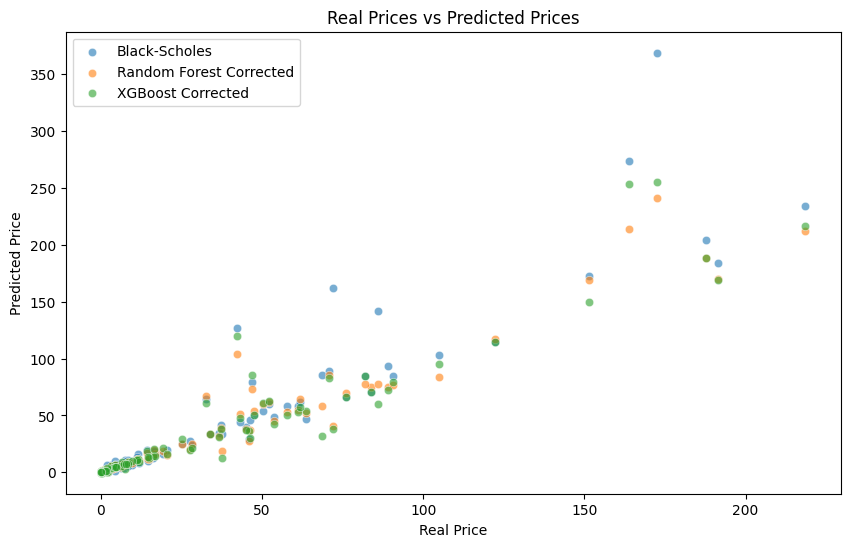

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot: Predicted vs Real Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=comparison_df['Real Price'], y=comparison_df['Black-Scholes Price'], label="Black-Scholes", alpha=0.6)
sns.scatterplot(x=comparison_df['Real Price'], y=comparison_df['RF Corrected Price'], label="Random Forest Corrected", alpha=0.6)
sns.scatterplot(x=comparison_df['Real Price'], y=comparison_df['XGB Corrected Price'], label="XGBoost Corrected", alpha=0.6)

plt.title('Real Prices vs Predicted Prices')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


The dashboard provides an interactive tool for visualizing option pricing, Greeks, and model performance. Users can select different stock tickers and explore historical vs predicted prices, option Greeks (Delta, Gamma), and pricing comparisons (Black-Scholes vs real-world prices). This helps users assess the accuracy of pricing models, understand option behavior, and make informed decisions. The dynamic, user-friendly interface enables real-time updates based on user input, enhancing analysis and comparison across different stocks. Overall, it aids in evaluating and improving option pricing models for more accurate financial forecasting.





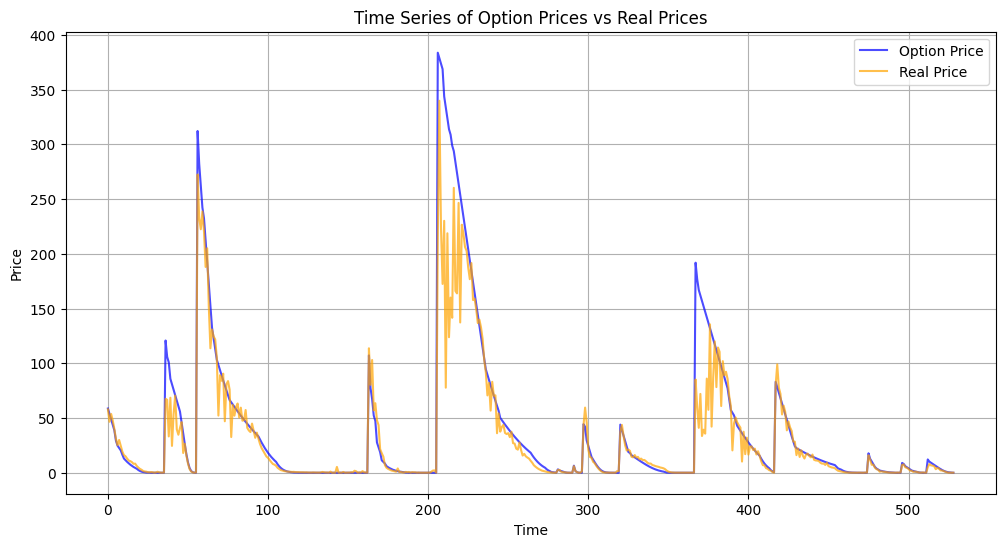

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series(df):
    # Ensure 'Date' is in datetime format, if applicable
    # If you have a 'Date' column in your dataset, use that. For now, I assume the index is a proxy for time.
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])

    plt.figure(figsize=(12, 6))

    # Plot for Option Price vs Time (using Date or the index as time)
    sns.lineplot(x=df.index, y=df['Price'], label="Option Price", color='blue', alpha=0.7)
    sns.lineplot(x=df.index, y=df['Real Price'], label="Real Price", color='orange', alpha=0.7)

    plt.title("Time Series of Option Prices vs Real Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_time_series(cleaned_predicted_prices_df)


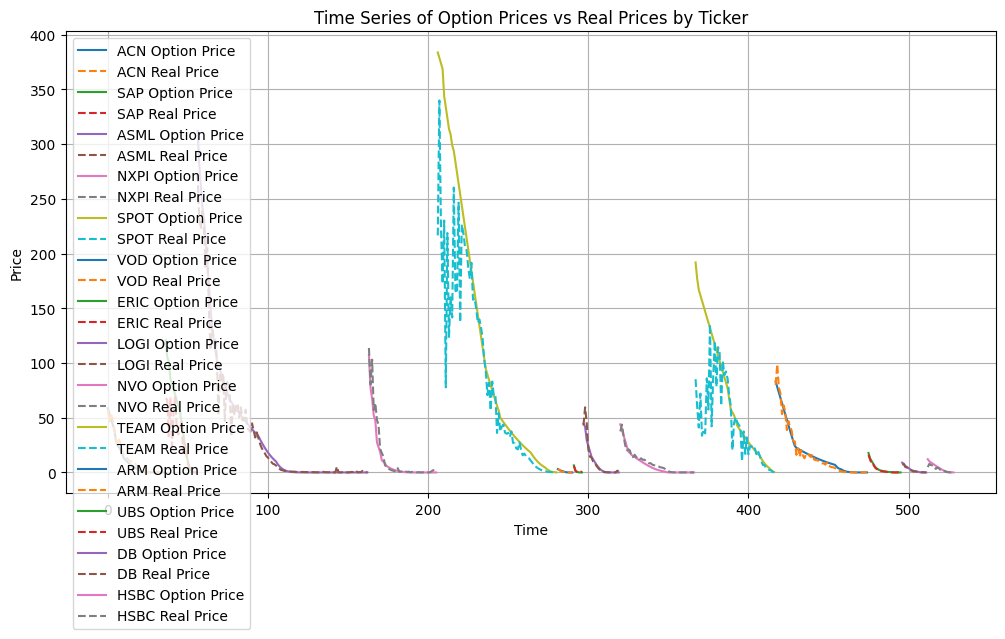

In [27]:
def plot_time_series_by_ticker(df):
    plt.figure(figsize=(12, 6))

    for ticker in df['Ticker'].unique():
        subset = df[df['Ticker'] == ticker]
        sns.lineplot(x=subset.index, y=subset['Price'], label=f"{ticker} Option Price")
        sns.lineplot(x=subset.index, y=subset['Real Price'], label=f"{ticker} Real Price", linestyle='--')

    plt.title("Time Series of Option Prices vs Real Prices by Ticker")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function
plot_time_series_by_ticker(cleaned_predicted_prices_df)


In [28]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
import pandas as pd

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1('Option Pricing Time Series Dashboard'),

    # Dropdown to select ticker
    dcc.Dropdown(
        id='ticker-dropdown',
        options=[{'label': ticker, 'value': ticker} for ticker in cleaned_predicted_prices_df['Ticker'].unique()],
        value=cleaned_predicted_prices_df['Ticker'].unique()[0],  # default value
        style={'width': '50%'}
    ),

    # Graph to show time series plot for the selected ticker
    dcc.Graph(id='time-series-graph'),
])

@app.callback(
    dash.dependencies.Output('time-series-graph', 'figure'),
    [dash.dependencies.Input('ticker-dropdown', 'value')]
)
def update_time_series(ticker):
    ticker_data = cleaned_predicted_prices_df[cleaned_predicted_prices_df['Ticker'] == ticker]


    if 'Date' in ticker_data.columns:
        ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

    trace1 = go.Scatter(
        x=ticker_data.index if 'Date' not in ticker_data.columns else ticker_data['Date'],
        y=ticker_data['Price'],
        mode='lines',
        name='Option Price',
        line=dict(color='blue', width=2)
    )

    trace2 = go.Scatter(
        x=ticker_data.index if 'Date' not in ticker_data.columns else ticker_data['Date'],
        y=ticker_data['Real Price'],
        mode='lines',
        name='Real Price',
        line=dict(color='orange', width=2, dash='dash')
    )

    figure = {
        'data': [trace1, trace2],
        'layout': go.Layout(
            title=f"Time Series of Option Prices vs Real Prices ({ticker})",
            xaxis={'title': 'Time'},
            yaxis={'title': 'Price'},
            hovermode='closest',
            template="plotly_dark"
        )
    }
    return figure

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

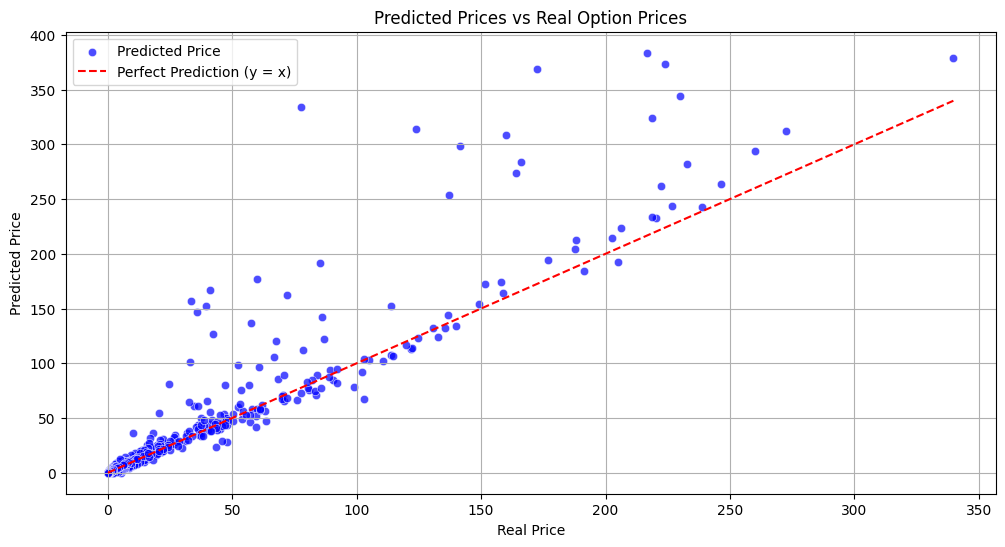

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the plot function
def plot_predicted_vs_real(df):
    plt.figure(figsize=(12, 6))

    # Plot the Predicted Prices vs Real Prices
    sns.scatterplot(x=df['Real Price'], y=df['Price'], label='Predicted Price', color='blue', alpha=0.7)

    # Add labels and title
    plt.title('Predicted Prices vs Real Option Prices')
    plt.xlabel('Real Price')
    plt.ylabel('Predicted Price')

    # Plot a diagonal line for perfect prediction (Real Price = Predicted Price)
    plt.plot([df['Real Price'].min(), df['Real Price'].max()],
             [df['Real Price'].min(), df['Real Price'].max()],
             color='red', linestyle='--', label='Perfect Prediction (y = x)')

    # Show the legend
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_predicted_vs_real(cleaned_predicted_prices_df)


<ipython-input-30-55a415a50cff>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




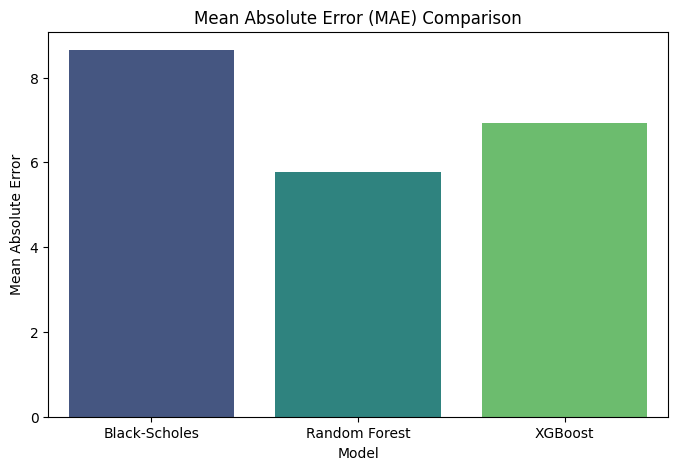

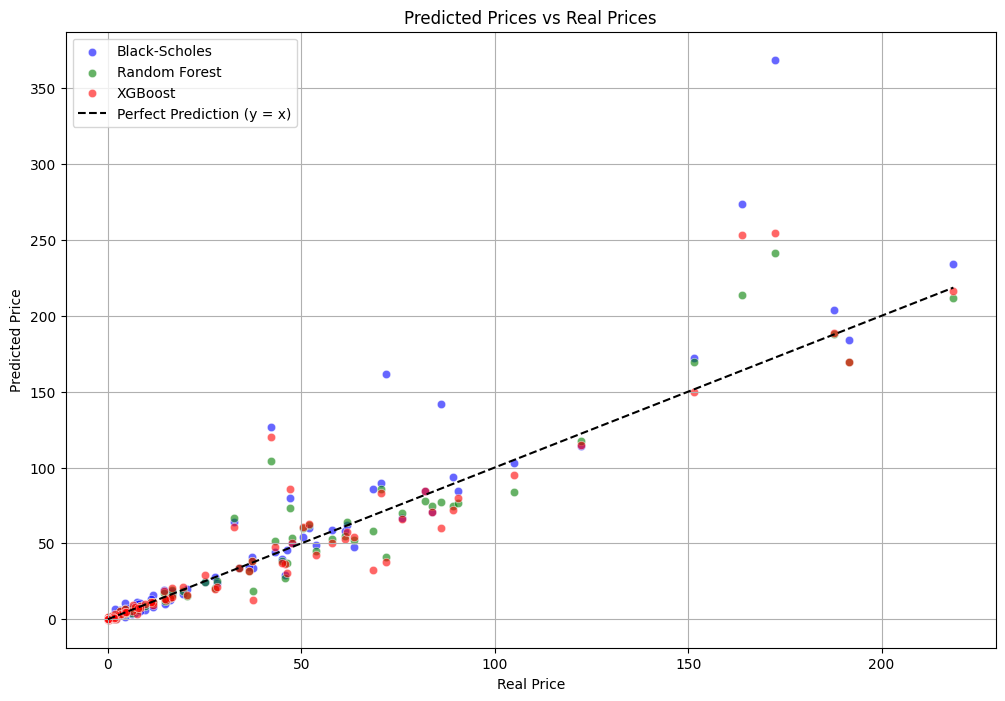

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Assuming 'comparison_df' contains columns: ['Real Price', 'Black-Scholes Price', 'RF Corrected Price', 'XGB Corrected Price']

# Calculate MAE for each model
mae_bs = mean_absolute_error(comparison_df['Real Price'], comparison_df['Black-Scholes Price'])
mae_rf = mean_absolute_error(comparison_df['Real Price'], comparison_df['RF Corrected Price'])
mae_xgb = mean_absolute_error(comparison_df['Real Price'], comparison_df['XGB Corrected Price'])

# Create a DataFrame for MAE comparison
mae_comparison = pd.DataFrame({
    'Model': ['Black-Scholes', 'Random Forest', 'XGBoost'],
    'MAE': [mae_bs, mae_rf, mae_xgb]
})

# Plot: MAE Comparison for Models
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='MAE', data=mae_comparison, palette='viridis')
plt.title('Mean Absolute Error (MAE) Comparison')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Model')
plt.show()

# Now let's visualize the comparison in terms of predicted vs real prices
plt.figure(figsize=(12, 8))

# Scatter Plot: Predicted vs Real Prices
sns.scatterplot(x=comparison_df['Real Price'], y=comparison_df['Black-Scholes Price'], label="Black-Scholes", alpha=0.6, color='blue')
sns.scatterplot(x=comparison_df['Real Price'], y=comparison_df['RF Corrected Price'], label="Random Forest", alpha=0.6, color='green')
sns.scatterplot(x=comparison_df['Real Price'], y=comparison_df['XGB Corrected Price'], label="XGBoost", alpha=0.6, color='red')

# Add perfect prediction line (y = x)
plt.plot([comparison_df['Real Price'].min(), comparison_df['Real Price'].max()],
         [comparison_df['Real Price'].min(), comparison_df['Real Price'].max()],
         color='black', linestyle='--', label='Perfect Prediction (y = x)')

plt.title('Predicted Prices vs Real Prices')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.grid(True)
plt.show()
